## Import Libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

## Loading data

In [2]:
df = pd.read_csv('debates_2022.csv')
df.head()

,Unnamed: 0,speaker_name,speaker_role,speaker_party,date,year,debate_title,talk_text
0,81414,Roberta Metsola,NaN,NaN,2022-01-17,2022,Resumption of the session,declaration repeats the session of the europe...
1,81415,Roberta Metsola,NaN,NaN,2022-01-17,2022,Memorial ceremony for President David Maria Sa...,it is with great sadness that today we are pr...
2,81416,Enrico Letta,NaN,NaN,2022-01-17,2022,Memorial ceremony for President David Maria Sa...,secretary of the italian democratic party and...
3,81417,Roberta Metsola,NaN,NaN,2022-01-17,2022,Memorial ceremony for President David Maria Sa...,there will be a musical interlude for a few mi...
4,81418,Charles Michel,NaN,NaN,2022-01-17,2022,Memorial ceremony for President David Maria Sa...,president of the european council. “mr. presi...


In [3]:
texts = df['talk_text']

In [4]:
texts

0         declaration repeats the session of the europe...
1         it is with great sadness that today we are pr...
2         secretary of the italian democratic party and...
3        there will be a musical interlude for a few mi...
4         president of the european council. “mr. presi...
                               ...                        
14492                             that concludes the item.
14493    the minutes of this sitting will be submitted ...
14494    the next part-session will take place from 16–...
14495    let me wish you all merry christmas and happy ...
14496    i declare adjourned the session of the europea...
Name: talk_text, Length: 14497, dtype: object

## Preprocessing Text

In [5]:
def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()
    
    # 2. Removing non-alphanumeric characters (keeping spaces and letters only)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 3. Tokenization (splitting text into words)
    words = nltk.word_tokenize(text)
    
    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # 5. Lemmatization (to reduce words to their base form)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # 6. Join words back into a string
    return ' '.join(words)

# Apply preprocessing to the text data
preprocessed_texts = texts.apply(preprocess_text)

In [6]:
preprocessed_texts

0        declaration repeat session european parliament...
1        great sadness today preparing give last commit...
2        secretary italian democratic party former pres...
3        musical interlude minute musical interlude cel...
4        president european council mr president europe...
                               ...                        
14492                                       concludes item
14493    minute sitting submitted parliament approval b...
14494                  next partsession take place january
14495    let wish merry christmas happy new year behalf...
14496        declare adjourned session european parliament
Name: talk_text, Length: 14497, dtype: object

## Vectorizing text using TfidfVectorizer

In [7]:
vectorizer = TfidfVectorizer(
    max_df=0.90,  # Ignore words that appear in more than 90% of documents
    min_df= 10,     # Ignore words that appear in less than 10 documents
    ngram_range=(1, 1),  # Use unigrams
    stop_words='english',  # Remove common English stopwords
    max_features= 10000
)

In [8]:
X = vectorizer.fit_transform(preprocessed_texts)

In [9]:
X

<14497x7689 sparse matrix of type '<class 'numpy.float64'>'
	with 1089385 stored elements in Compressed Sparse Row format>

In [10]:
print("Features (Top 20):", vectorizer.get_feature_names_out()[:20])

Features (Top 20): ['abandon' 'abandoned' 'abandonment' 'ability' 'able' 'abolish'
 'abolished' 'abolishing' 'abolition' 'abortion' 'abraham' 'abroad'
 'absence' 'absent' 'absolute' 'absolutely' 'absorb' 'absorption'
 'abstain' 'abstained']


In [11]:
# Convert the matrix to a DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Display the top few rows of the TF-IDF DataFrame
print(tfidf_df.head())

    abandon  abandoned  abandonment  ability      able   abolish  abolished  \
0  0.000000        0.0          0.0      0.0  0.000000  0.000000        0.0   
1  0.067023        0.0          0.0      0.0  0.000000  0.000000        0.0   
2  0.018903        0.0          0.0      0.0  0.009254  0.018903        0.0   
3  0.000000        0.0          0.0      0.0  0.000000  0.000000        0.0   
4  0.000000        0.0          0.0      0.0  0.017647  0.000000        0.0   

   abolishing  abolition  abortion  ...    youve  yugoslavia  zagreb  zealand  \
0         0.0        0.0       0.0  ...  0.00000         0.0     0.0      0.0   
1         0.0        0.0       0.0  ...  0.00000         0.0     0.0      0.0   
2         0.0        0.0       0.0  ...  0.00000         0.0     0.0      0.0   
3         0.0        0.0       0.0  ...  0.00000         0.0     0.0      0.0   
4         0.0        0.0       0.0  ...  0.03122         0.0     0.0      0.0   

   zelensky  zelenskyy  zen  zero  zer

In [12]:
tfidf_df.shape

(14497, 7689)

# Select K value using Elbow method.

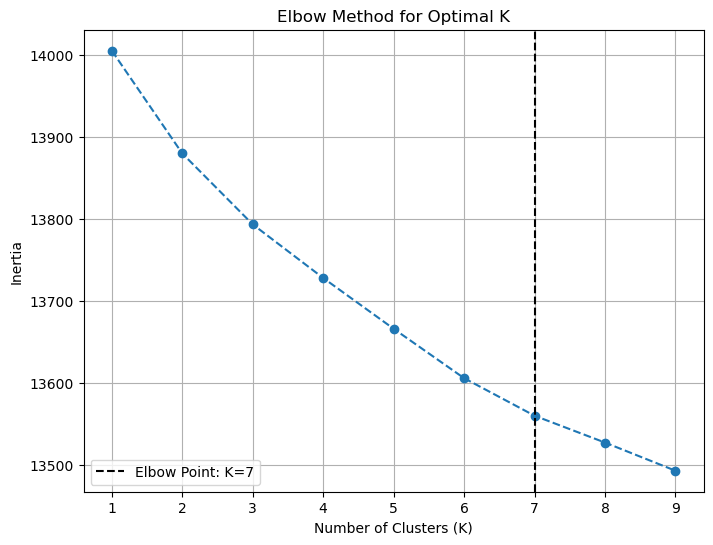

Optimal number of clusters (elbow point): 7


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Range of clusters to try
k_range = range(1, 10)

# List to store inertia values for each K
inertia = []

# Calculate inertia for each K
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)  # Set n_jobs=1 to disable parallelism
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Calculate the first derivative (difference between successive inertia values)
inertia_diff = np.diff(inertia)

# Find the index where the first derivative decreases the most (elbow point)
elbow_point = np.argmax(inertia_diff) + 1  # Adding 1 because the first diff is one less than the actual K

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.axvline(x=elbow_point, color='black', linestyle='--', label=f"Elbow Point: K={elbow_point}")
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.legend()
plt.show()

print(f"Optimal number of clusters (elbow point): {elbow_point}")

## Clustering

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Clustering using K-Means
num_clusters = elbow_point  # Set the number of clusters (You can adjust this based on evaluation metrics)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

# Evaluate clustering using silhouette score
sil_score = silhouette_score(X, labels)

# Show the results
print(f"Silhouette Score: {sil_score}")

# Extract the top 10 words for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# Display the top 10 words in each cluster
for i in range(num_clusters):
    print(f"Cluster {i+1} top 10 words:")
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(", ".join(top_words))
    print("\n")

Silhouette Score: 0.010380894158318606
Cluster 1 top 10 words:
vote, agenda, point, follows, rsp, session, minute, request, committee, voting


Cluster 2 top 10 words:
european, need, mr, commission, climate, member, eu, state, europe, union


Cluster 3 top 10 words:
ukraine, war, russia, putin, russian, ukrainian, european, people, europe, country


Cluster 4 top 10 words:
woman, right, violence, abortion, gender, girl, equality, sexual, men, afghanistan


Cluster 5 top 10 words:
european, right, mr, union, law, president, country, parliament, people, state


Cluster 6 top 10 words:
closed, discussion, written, statement, article, vote, ended, thursday, held, debate


Cluster 7 top 10 words:
energy, gas, price, european, need, crisis, renewable, market, electricity, nuclear




## Cluster Interpritation
### • Cluster 1: Focuses on parliamentary procedures and voting sessions, including agendas, points of order, and committee matters.
### • Cluster 2: Covers EU policy discussions on climate, governance, and the roles of member states and the European Commission.
### • Cluster 3: Centers on the Ukraine–Russia war, highlighting support for Ukraine and geopolitical tensions with Russia.
### • Cluster 4: Addresses gender equality and women’s rights, with emphasis on issues like abortion, violence, and discrimination.
### • Cluster 5: Involves general political discourse on EU law, human rights, and the functioning of the European Parliament.
### • Cluster 6: Reflects administrative and procedural communications such as statements, written dicussions, and session closures.
### • Cluster 7: Focuses on the European energy crisis, particularly gas prices, market conditions, and renewable energy solutions.

In [15]:
unique_labels = np.unique(labels)

# Get the number of clusters (excluding noise if desired)
num_clusters = len(unique_labels)  # Including noise
num_clusters_excluding_noise = len(unique_labels[unique_labels != -1])  # Excluding noise

print(f"Total number of labels (clusters including noise): {num_clusters}")
print(f"Total number of clusters (excluding noise): {num_clusters_excluding_noise}")

Total number of labels (clusters including noise): 7
Total number of clusters (excluding noise): 7


## Dimensionality reduction for Visualization

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X.toarray())

In [18]:
X_pca

array([[ 0.13726053, -0.01384284],
       [-0.01685419, -0.08784643],
       [-0.04270698, -0.06395057],
       ...,
       [ 0.09253575, -0.01263513],
       [ 0.1038935 , -0.01436575],
       [ 0.07476312, -0.03745409]])

In [19]:
X_pca.shape

(14497, 2)

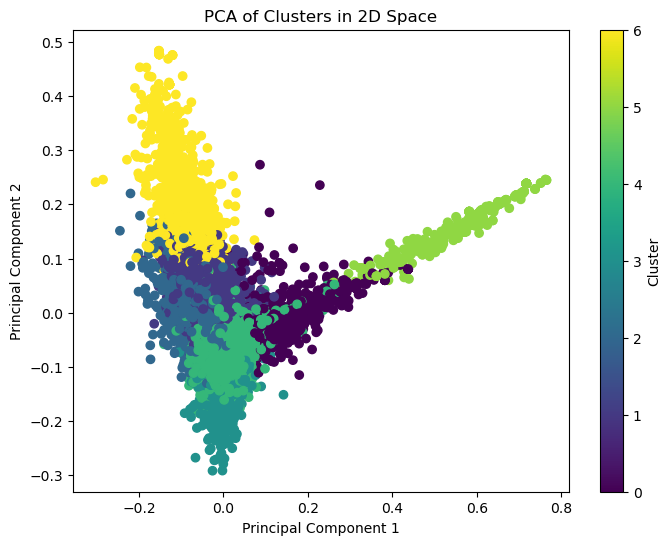

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title("PCA of Clusters in 2D Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [21]:
# Get the components and feature names
components = pca.components_
feature_names = vectorizer.get_feature_names_out()

# Top 10 contributing terms to PC1 and PC2
top_n = 20

pc1_top_indices = components[0].argsort()[::-1][:top_n]
pc2_top_indices = components[1].argsort()[::-1][:top_n]

print("Top words for PC1:")
print([feature_names[i] for i in pc1_top_indices])

print("\nTop words for PC2:")
print([feature_names[i] for i in pc2_top_indices])

Top words for PC1:
['closed', 'vote', 'discussion', 'statement', 'written', 'article', 'thursday', 'agenda', 'held', 'ended', 'tomorrow', 'debate', 'place', 'point', 'tuesday', 'follows', 'wednesday', 'submitted', 'minute', 'session']

Top words for PC2:
['energy', 'price', 'gas', 'closed', 'written', 'discussion', 'crisis', 'statement', 'supply', 'renewable', 'vote', 'electricity', 'market', 'need', 'article', 'climate', 'nuclear', 'fossil', 'green', 'food']


## PCA dimensions Interpretation:
### • PCA-1 This dimension reflects parliamentary procedure and session management, as it is dominated by terms related to voting, agenda items, debates, and scheduling (e.g., ”vote”, ”agenda”, ”minute”, ”session”, ”discussion”).
### • PCA-2 This dimension emphasizes policy discussions related to energy, climate, and crisis manage ment, indicated by words such as ”energy”, ”crisis”, ”gas”, ”renewable”, and ”climate”.
